In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import random

import shap
import torch

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle as pkl

from shapreg import shapley, games, removal, shapley_sampling
from typing import List
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

from denoising_diffusion_pytorch import Unet, GaussianDiffusion

from dataset import Dataset

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)
    
module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_feature_values(feature_values, x_test, feature_names):

    feature_num = feature_values.shape[1]
    ind = np.argpartition(np.abs(feature_values).mean(0), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(np.array(feature_names)[ind], np.abs(feature_values[:, ind]).mean(0).round(4))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        show=False
    )
    
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    # plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('CRASH-2 - Shapley Value', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.4, -2.5, "TXA worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.4, -2.5, "TXA better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)

    plt.show()
    

def plot_feature_values_ind(feature_values, indices):
    
    feature_num = feature_values.shape[1]

    selected_sample = feature_values[indices]
    filtered_test = x_test[indices]
    
    ind = np.argpartition(np.abs(selected_sample).mean(0).round(2), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(selected_sample[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        selected_sample[:, ind],
        filtered_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

def min_max_norm(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train

def standardization(x_train):
    
    x_normalized_train = (x_train - np.mean(x_train, axis=0)) / (np.std(x_train, axis=0))

    return x_normalized_train

def subgroup_ate(
    method: str,
    features: List[int],
    y_true_train: np.ndarray,
    y_true_test: np.ndarray,
    estimated_ate_test: np.ndarray,
) -> None:
    
    xgb_model = xgb.XGBClassifier(  
        max_depth=10,
        reg_lambda=2,
        # min_split_loss=2
    )

    xgb_model.fit(x_train[:, features], y_true_train)

    y_pred = xgb_model.predict(x_test[:, features])
    y_pred_train = xgb_model.predict(x_train[:, features])
    
    ate = np.sum(estimated_ate_test[y_pred == 1])/len(estimated_ate_test)
    auroc = metrics.roc_auc_score(y_true_test, y_pred)
        
    print("===================")
    print("%s - auroc %s"%(method, auroc))
    print("%s - ATE %s"%(method, ate))

def feature_idx(
    method: str,
    cohort: str,
    learner: str
)-> List[int]:
    
    if method == "shap":
        file_path = f"../results/{cohort}/naive_shap_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "ig":
        file_path = f"../results/{cohort}/integrated_gradients_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "shap - 0 ":
        file_path = f"../results/{cohort}/shapley_value_sampling_top_5_features_shuffle_{shuffle}_{learner}.csv"
        
    df = pd.read_csv(file_path,keep_default_na=False)
    
    df_sorted = df.sort_values(
        by='count (%)', 
        ascending=False
    )
    print(df_sorted["feature"].head(5).tolist())
    
    indices  = [ data.columns.get_loc(col) for col in df_sorted["feature"].head(5) ]
    print(indices)
    
    indices = [i-1 if i > treatment_index else i for i in indices]
    indices = [i-1 if i > outcome_index else i for i in indices]

    return indices



In [13]:
data = Dataset("crash_2", 10)

x, w, y = data.get_data()

x_train, w_train, y_train = data.get_data("train")
x_val, w_val, y_val = data.get_data("val")
x_test, w_test, y_test = data.get_data("test")


injury_mapping = {
    "iinjurytype_1": "Blunt",
    "iinjurytype_2": "Penetrating"
}

feature_names = [injury_mapping.get(name, name) for name in data.get_feature_names()]

Output 0.010745588370950987: 95% CI = (0.000, 0.018)


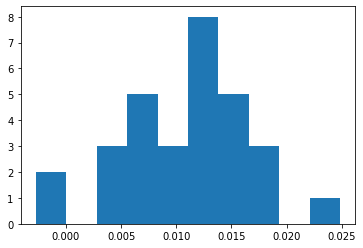

In [16]:
predict_results  = pkl.load(open("results/crash_2/predict_results.pkl", 'rb'))

np.median(predict_results), np.std(predict_results)/np.sqrt(len(predict_results))

mean_ates = predict_results.mean(1)

plt.hist(mean_ates, bins=10)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output {mean_ates.mean(0)}: 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

Text(0, 0.5, 'Frequency')

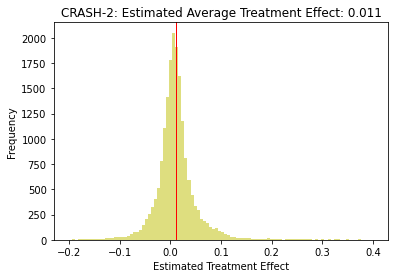

In [64]:
# plt.figure(figsize=(5, 3))

plt.hist(
    np.mean(results, axis=0), 
    bins=100, 
    range=(-0.2,0.4),
    alpha= 0.5, 
    color="y"
)
plt.axvline(x= np.mean(results), linewidth=1, color='r')

plt.title("CRASH-2: Estimated Average Treatment Effect: "+ str(np.round(np.mean(results) , 3)))
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")

In [69]:
np.mean(results), np.std(results)

(0.011321450003002763, 0.057042886213568726)

In [91]:
data = Dataset("crash_2", 0)

x, w, y = data.get_data()

trials = 10

results = np.zeros((trials, len(x)))

model = pseudo_outcome_nets.XLearner(  
    x.shape[1],
    binary_y=(len(np.unique(y)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1000,
    nonlin="relu",
    device="cpu",
)

model.fit(x, y, w)
# results[i] = model.predict(x).detach().cpu().numpy().reshape(-1)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.5956066250801086, train_loss: 0.6344470381736755
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.33683496713638306, train_loss: 0.31793656945228577
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.33674779534339905, train_loss: 0.31572848558425903
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.3366980254650116, train_loss: 0.31579598784446716
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.3367374539375305, train_loss: 0.3122965693473816
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.5390946269035339, train_loss: 0.5824242234230042
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.31574106216430664, train_loss: 0.29990020394325256
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.3150383234024048, train_loss: 0.29305046796798706
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.315

XLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (_propensity_estimato

In [92]:
baseline = np.mean(x,axis=0)

# for k, idx_lst in data.discrete_indices.items():   
    
#     if len(idx_lst) == 1:

#         baseline[idx_lst] = 0.5
#     else:

#         baseline[idx_lst] = 1/len(idx_lst)


In [93]:
marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

marginal_shapley_value = marginal_shapley_value_sampling_model.attribute(
                torch.tensor(x),
                n_samples=1000,
                baselines = torch.tensor(baseline.reshape(1,-1)),
                perturbations_per_eval = 1,
                show_progress=True
).detach().cpu().numpy()


Shapley Value Sampling attribution: 100%|███████████████████| 10001/10001 [03:39<00:00, 45.50it/s]


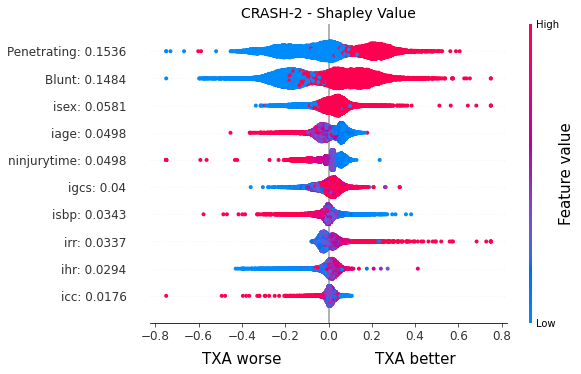

In [130]:
marginal_shapley_value =  np.where(marginal_shapley_value > 0.75, 0.75, marginal_shapley_value)
marginal_shapley_value =  np.where(marginal_shapley_value < -0.75, -0.75, marginal_shapley_value)

plot_feature_values(
    marginal_shapley_value, 
    x,
    feature_names
)

In [129]:
marginal_shapley_value[:,[ 1,4 ]] = marginal_shapley_value[:,[4, 1]]
x[:, [1,4]] = x[:, [4,1]] 
# marginal_shapley_value[:,-2] = marginal_shapley_value[:,-1]



feature_names

['iage',
 'isbp',
 'irr',
 'icc',
 'ihr',
 'ninjurytime',
 'igcs',
 'isex',
 'Blunt',
 'Penetrating']

In [225]:
shap.initjs()

x_raw_con = data.get_unnorm_value(x)
x_raw = np.concatenate([x_raw_con, x[:, x_raw_con.shape[1]:]], axis=1)

injury_mapping = {
    "iinjurytype_1": "Blunt",
    "iinjurytype_2": "Penetrating"
}

feature_names = [injury_mapping.get(name, name) for name in data.get_feature_names()]

baseline_output = (model.predict(x[208,:].reshape(1,-1)).detach().cpu().numpy()).flatten()

exp = shap.Explanation(
    marginal_shapley_value,  
    baseline_output[0],
    data=x_raw,
    feature_names=feature_names
)

shap.plots.force(exp[4]) 

In [37]:
predict_results  = pkl.load(open("results/crash_2/predict_results.pkl", 'rb'))

np.mean(predict_results), np.std(predict_results)/np.sqrt(predict_results.shape[0])

(0.008888176478469506, 0.014245674064106718)

In [38]:
avg_shap = pkl.load(open("results/crash_2/shap_bootstrapped.pkl",'rb'))

avg_shap.mean(0).shape

(16845, 10)

In [39]:
avg_shap = pkl.load(open("results/crash_2/shap_bootstrapped.pkl",'rb'))

avg_shap = avg_shap.mean(0)
# avg_shap =  np.where(avg_shap > 0.4, 0.1, avg_shap)

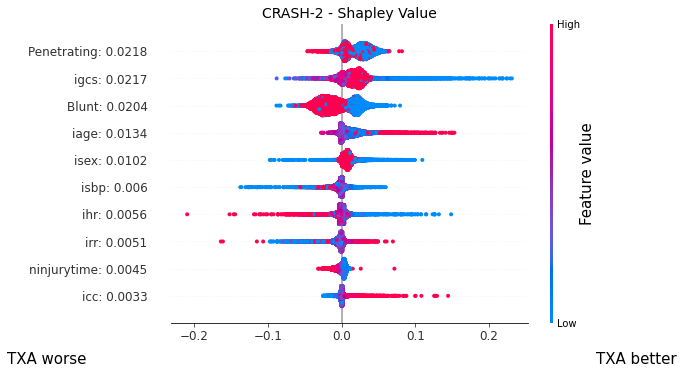

In [40]:
data = Dataset("crash_2", 0)

x, y, w = data.get_data()

plot_feature_values(
    avg_shap, 
    x,
    feature_names
)

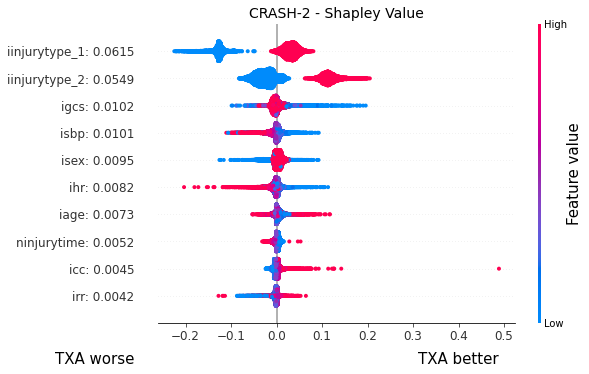

In [133]:
data = Dataset('crash_2', 0)

avg_shap = pkl.load(open("results/crash_2/avg_shap.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0),
    x, 
    data.get_feature_names()
)

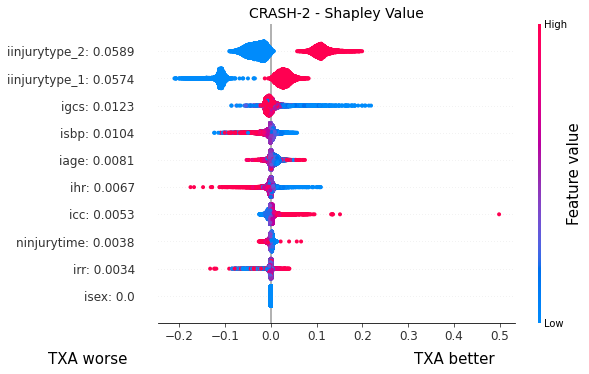

In [139]:
avg_shap = pkl.load(open("results/crash_2/isex=1.0_shap.pkl",'rb'))

gender_index = data.get_feature_names().tolist().index('isex')

plot_feature_values(
    avg_shap.mean(0), 
    x[x[:, gender_index]== 1], 
    data.get_feature_names()
)

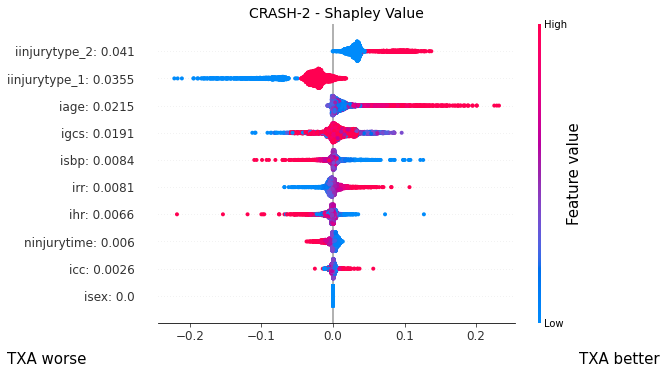

In [140]:
avg_shap = pkl.load(open("results/crash_2/isex=0.0_shap.pkl",'rb'))

gender_index = data.get_feature_names().tolist().index('isex')

plot_feature_values(
    avg_shap.mean(0), 
    x[x[:, gender_index]== 0], 
    data.get_feature_names()
)

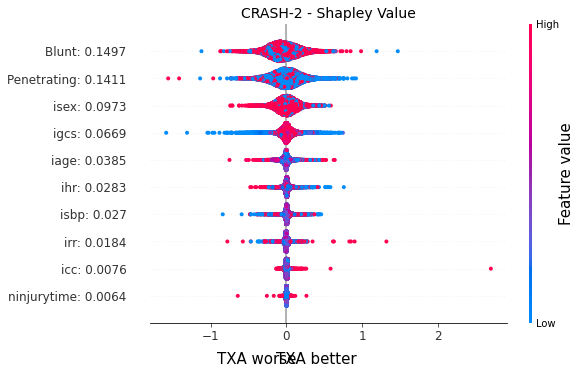

In [18]:
gradient_shap_model = GradientShap(model)

gradientshap = gradient_shap_model.attribute(
    torch.tensor(x), 
    baselines = torch.tensor(baseline.reshape(1,-1)),
).detach().cpu().numpy()

plot_feature_values(gradientshap, x, feature_names)

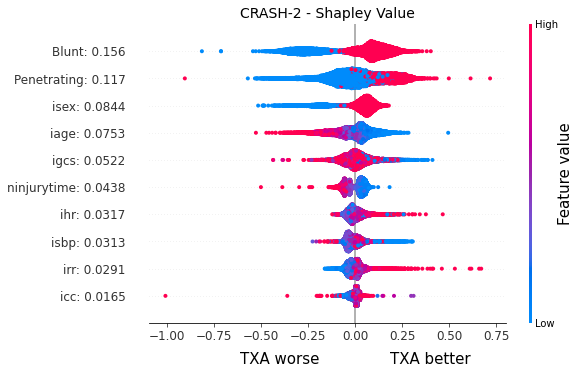

In [31]:
plot_feature_values(marginal_shapley_value, x, feature_names)

In [19]:
plot_feature_values(marginal_shapley_value, x, feature_names)

NameError: name 'marginal_shapley_value' is not defined

In [28]:
marginal_shapley_value[:, -1] = -marginal_shapley_value[:, -1]
marginal_shapley_value[:, -2] = -marginal_shapley_value[:, -2]

In [8]:
kernel_shap_model = KernelShap(model)

kernel_shapley_value = kernel_shap_model.attribute(
                torch.tensor(x),
                n_samples=1000,
                # baselines = torch.tensor(baseline.reshape(1,-1)),
                perturbations_per_eval = 10,
                # show_progress=True
).detach().cpu().numpy()

plot_feature_values(marginal_shapley_value, x, feature_names)

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.


KeyboardInterrupt: 

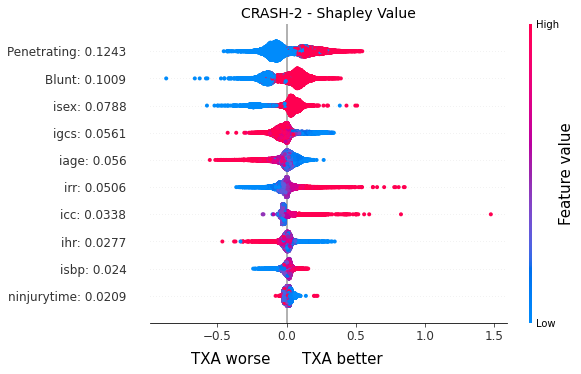

In [36]:
np.mean(marginal_shapley_value, axis=0)

array([-0.00084579,  0.00281964, -0.0028605 , -0.0020942 ,  0.00283738,
        0.01278219, -0.00413693,  0.00645157, -0.00229954,  0.02325756],
      dtype=float32)

Permutation explainer: 10781it [09:24, 18.75it/s]                               


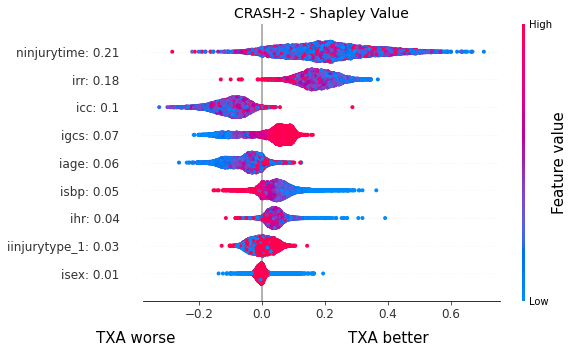

In [131]:
def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

# baseline = np.concatenate([x_train, x_val, x_test], axis=0)

explainer = shap.explainers.Permutation(model_predict, sample_seq)
shap_values = explainer(x_train)

plot_feature_values(shap_values.values, x_train)

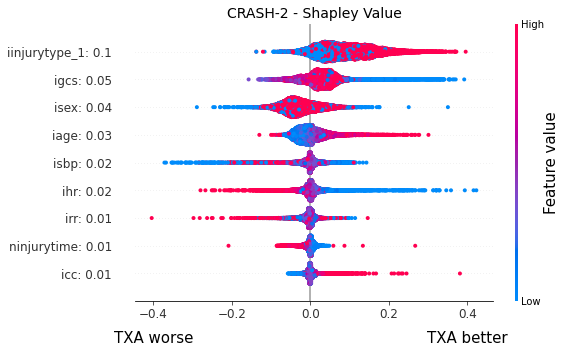

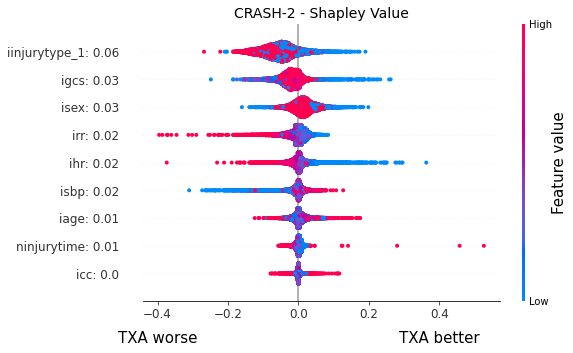

In [159]:
plot_feature_values(marginal_shapley_value, baseline)

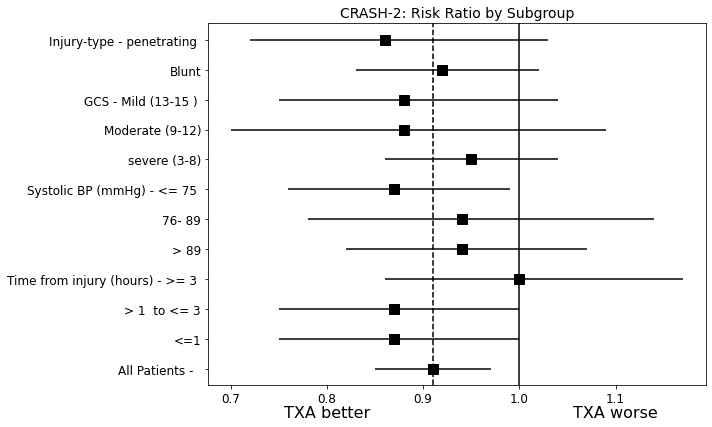

In [11]:
import matplotlib.pyplot as plt

# Data
data = [
    ["", 0.91, 0.85, 0.97,"All Patients"],
    ['<=1', 0.87, 0.75, 1.0, 'Time from injury (hours)'],
    ['> 1  to <= 3', 0.87, 0.75, 1.0, 'Time from injury (hours)'],
    ['>= 3', 1.0, 0.86, 1.17, 'Time from injury (hours)'],
    ['> 89', 0.94, 0.82, 1.07, 'Systolic BP (mmHg)'],
    ['76- 89', 0.94, 0.78, 1.14, 'Systolic BP (mmHg)'],
    ['<= 75', 0.87, 0.76, 0.99, 'Systolic BP (mmHg)'],
    ['severe (3-8)', 0.95, 0.86, 1.04, 'GCS'],
    ['Moderate (9-12)', 0.88, 0.70, 1.09, 'GCS'],
    ['Mild (13-15 )',0.88, 0.75, 1.04, 'GCS'],
    ['Blunt', 0.92, 0.83, 1.02, 'Injury-type'],
    ['penetrating', 0.86, 0.72, 1.03, 'Injury-type']
]

labels, medians, mins, maxs, categories = zip(*data)

# Compute the errors
lower_err = [median - min_ for median, min_ in zip(medians, mins)]
upper_err = [max_ - median for max_, median in zip(maxs, medians)]
errors = [lower_err, upper_err]

fig, ax = plt.subplots(figsize=(10,6))

# Plotting
y_range = range(len(labels))

# Reversing order
y_range = y_range[::-1]
medians = medians[::-1]
errors = [errors[0][::-1], errors[1][::-1]]

plt.errorbar(medians, y_range, xerr=errors, fmt='s', color="black", markersize=10)

# Set labels with category after range
new_labels = []
last_category = None
for label, min_, max_, category in reversed(list(zip(labels, mins, maxs, categories))):
    if category != last_category:
        new_labels.append(f'{category} - {label} ')
        last_category = category
    else:
        new_labels.append(f'{label}')

ax.set_yticks(y_range)
ax.set_yticklabels(new_labels, fontsize=12) # Larger font size here

ax.tick_params(axis='x', labelsize=12) # Larger font size for x-axis ticks

# Add custom text to the x-axis
ax.text(0.8, -1.6, "TXA better", color="black", ha="center", fontsize=16) # Larger font size here
ax.text(1.1, -1.6, "TXA worse", color="black", ha="center", fontsize=16) # Larger font size here

# Add a vertical dashed line at x = 0.91
ax.axvline(0.91, color='black', linestyle='--')
ax.axvline(1.0, color='black', linestyle='-')

plt.title("CRASH-2: Risk Ratio by Subgroup", size=14)
plt.tight_layout()
plt.show()


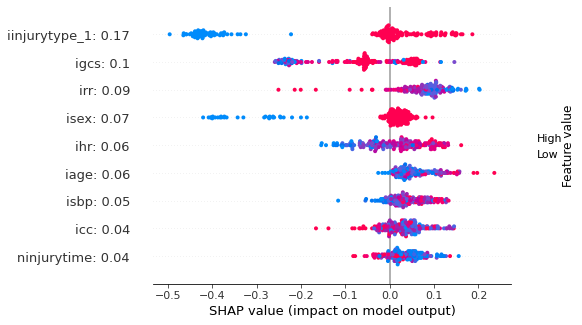

In [6]:
# print(learner_explanations["shapley_sampling"].shape)
plot_feature_values(learner_explanations["shapley_sampling"])

average tx effect 0.008960756681133409
average tx effect 0.008500801782337225


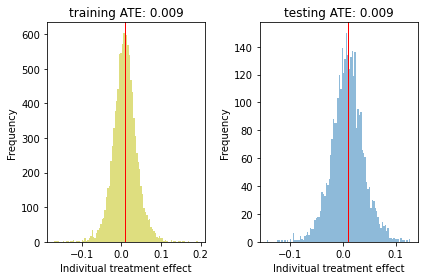

In [368]:
learner = "XLearner"
shuffle = "True"

results_train = pkl.load(open(f"../results/crash_2/train_shuffle_{shuffle}_{learner}.pkl", "rb"))
results_test = pkl.load(open(f"../results/crash_2/test_shuffle_{shuffle}_{learner}.pkl", "rb"))

print("average tx effect", np.mean(results_train))
print("average tx effect", np.mean(results_test))

plt.subplot(1,2,1)
plt.hist(np.mean(results_train, axis=0), bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(results_train), linewidth=1, color='r')

plt.title("training ATE: "+ str(np.round(np.mean(results_train), 3)))
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(np.mean(results_test, axis=0), bins=100, alpha = 0.5)
plt.axvline(x= np.mean(results_test), linewidth=1, color='r')

plt.title("testing ATE: "+ str(np.round(np.mean(results_test), 3)))
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

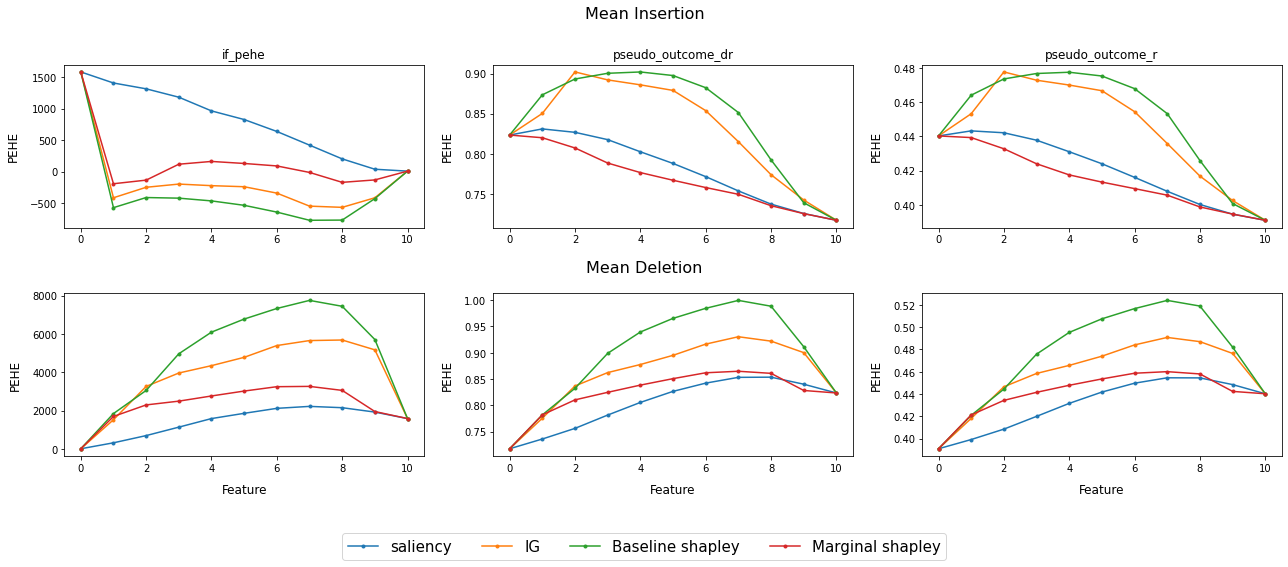

In [125]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

perturb_results_1 = []
perturb_results_2 = []
ablation_pos = {exp: [] for exp in explainers}
ablation_neg = {exp: [] for exp in explainers}

# Loop over the different files

seeds = [i for i in range(5)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:
    file_path = f"results/crash_2/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
    results = pkl.load(open(file_path,'rb'))
    
    for exp_index, exp in enumerate(explainers):
        auroc_all[exp].append(results[exp_index][5])
        auroc_ate[exp].append(results[exp_index][4])

        auroc_full.append(results[exp_index][7])
        auroc_full_ate.append(results[exp_index][6])

        auroc_random.append(results[exp_index][9])
        auroc_random_ate.append(results[exp_index][8])
        
        perturb_results_1.append(results[exp_index][10])
        perturb_results_2.append(results[exp_index][11])
        ablation_pos[exp].append(results[exp_index][12])
        ablation_neg[exp].append(results[exp_index][13])
        

        for selection_type in selection_types:
            
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))


# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)
        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


# Ablation study (Positive)

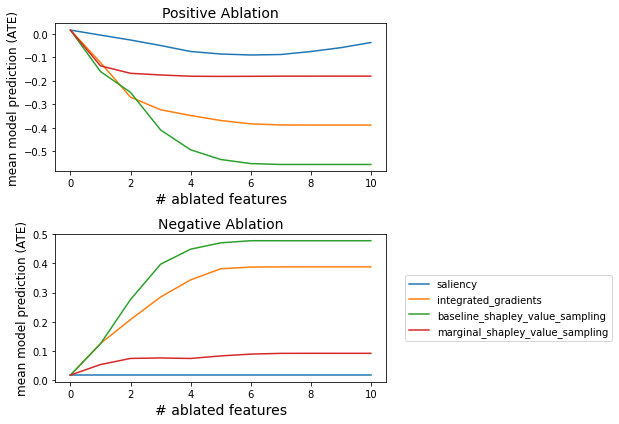

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ablation_pos and ablation_neg are dictionaries you have from elsewhere in your code

# Positive Ablation
ablation_results_pos = {exp: np.array(result).mean(axis=0) for exp, result in ablation_pos.items()}
ablation_stds_pos = {exp: np.array(result).std(axis=0) for exp, result in ablation_pos.items()}

# Negative Ablation
ablation_results_neg = {exp: np.array(result).mean(axis=0) for exp, result in ablation_neg.items()}
ablation_stds_neg = {exp: np.array(result).std(axis=0) for exp, result in ablation_neg.items()}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# Positive Ablation Plot
for k, v in ablation_results_pos.items():
    feature_num = np.arange(v.shape[0])
    axes[0].plot(feature_num, v, label=k)
    # axes[0].fill_between(
    #     feature_num,
    #     v + ablation_stds_pos[k],
    #     v - ablation_stds_pos[k],
    #     alpha=0.1
    # )
axes[0].set_title("Positive Ablation", size=14)
axes[0].set_ylabel("mean model prediction (ATE)", size=12)
axes[0].set_xlabel("# ablated features", size=14)
# axes[0].legend(loc='center right', bbox_to_anchor=(1.7, 0.5))

# Negative Ablation Plot
for k, v in ablation_results_neg.items():
    feature_num = np.arange(v.shape[0])
    axes[1].plot(feature_num, v, label=k)
    # axes[1].fill_between(
    #     feature_num,
    #     v + ablation_stds_neg[k],
    #     v - ablation_stds_neg[k],
    #     alpha=0.1
    # )
axes[1].set_title("Negative Ablation", size=14)
axes[1].set_ylabel("mean model prediction (ATE)", size=12)
axes[1].set_xlabel("# ablated features", size=14)
axes[1].legend(loc='center right', bbox_to_anchor=(1.7, 0.5))

# Display the combined figure
plt.tight_layout()
plt.show()


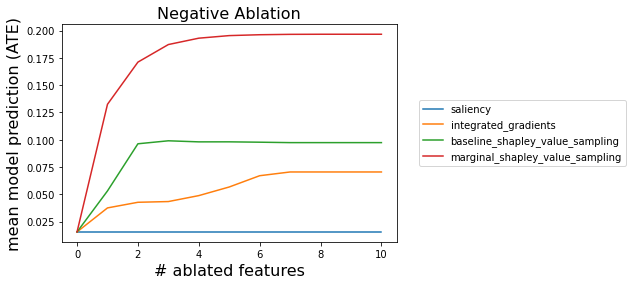

In [118]:
ablation_results  = {exp: np.array(result).mean(axis=0) for exp, result in ablation_neg.items()}
ablation_stds  = {exp: np.array(result).std(axis=0) for exp, result in ablation_neg.items()}

for k, v in ablation_results.items():
    
    feature_num = np.arange(v.shape[0])
    plt.plot(feature_num, v, label=k)
    # plt.fill_between(
    #     feature_num,
    #     v + ablation_stds[k],
    #     v - ablation_stds[k],
    #     alpha=0.1
    # )

plt.title("Negative Ablation", size=16)
plt.ylabel("mean model prediction (ATE)",  size=16)
plt.xlabel("# ablated features",  size=16)
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5))
plt.show()

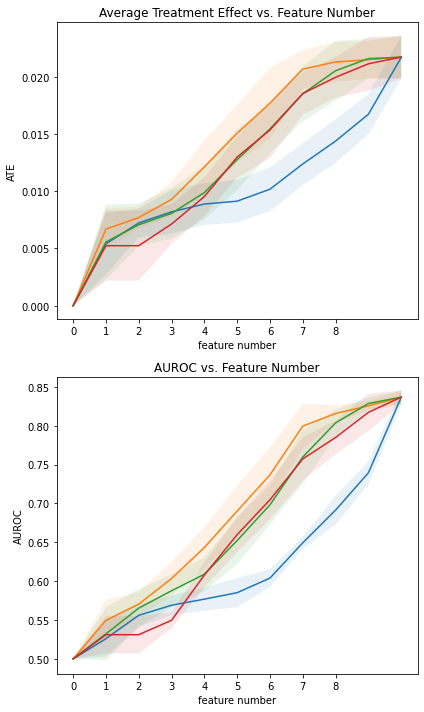

In [66]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}
auroc_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_all.items()}

ate_results = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}
ate_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_ate.items()}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,10))

# Plot ATE results
for k, v in ate_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
    ax1.fill_between(
        feature_num,
        np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
        np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
        alpha=0.1
    )

ax1.set_xticks(range(0, 9, 1))
ax1.set_xlabel("feature number")
ax1.set_ylabel("ATE")
ax1.set_title("Average Treatment Effect vs. Feature Number")

# Plot AUROC results
for k, v in auroc_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax2.plot(feature_num, np.insert(v, 0, 0.5), label=k)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0.5) + np.insert(auroc_std[k], 0, 0),
        np.insert(v, 0, 0.5) - np.insert(auroc_std[k], 0, 0),
        alpha=0.1
    )

ax2.set_xticks(range(0, 9, 1))
ax2.set_xlabel("feature number")
ax2.set_ylabel("AUROC")
ax2.set_title("AUROC vs. Feature Number")

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()

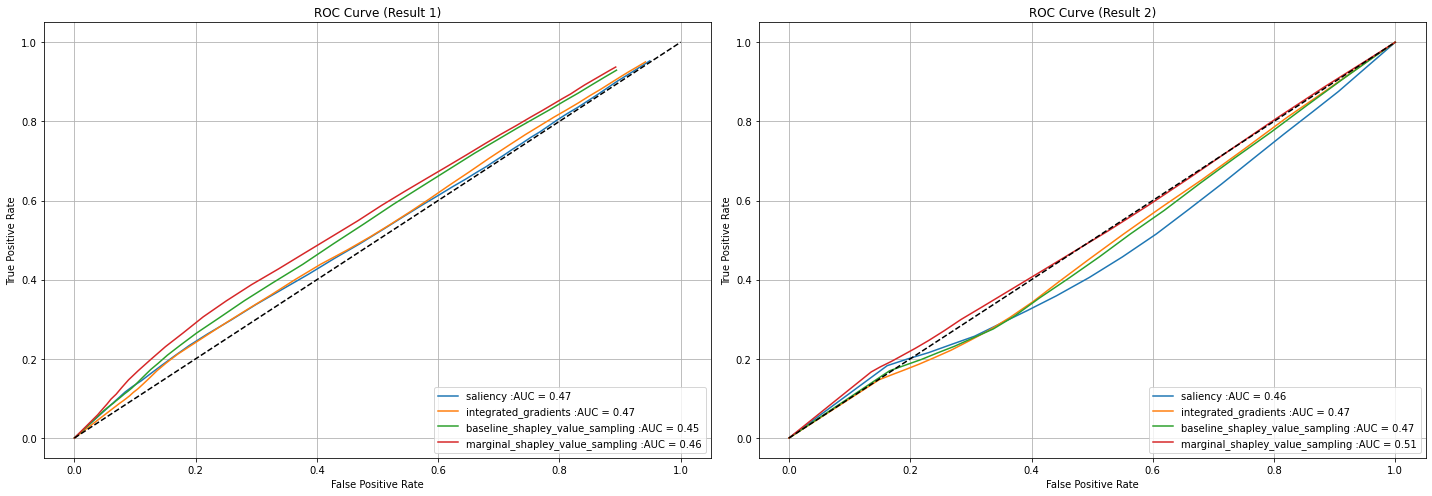

In [105]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

for i, exp in enumerate(explainers):

    data = np.mean(perturb_results_1[5 * i:5 * (i + 1)], axis=0)
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]
    ax1.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f}')
    
    data = np.mean(perturb_results_2[5 * i:5 * (i + 1)], axis=0)
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]
    ax2.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f}')

# Formatting for the first plot
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve (Result 1)')
ax1.legend(loc='lower right')
ax1.grid(True)

# Formatting for the second plot
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve (Result 2)')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()


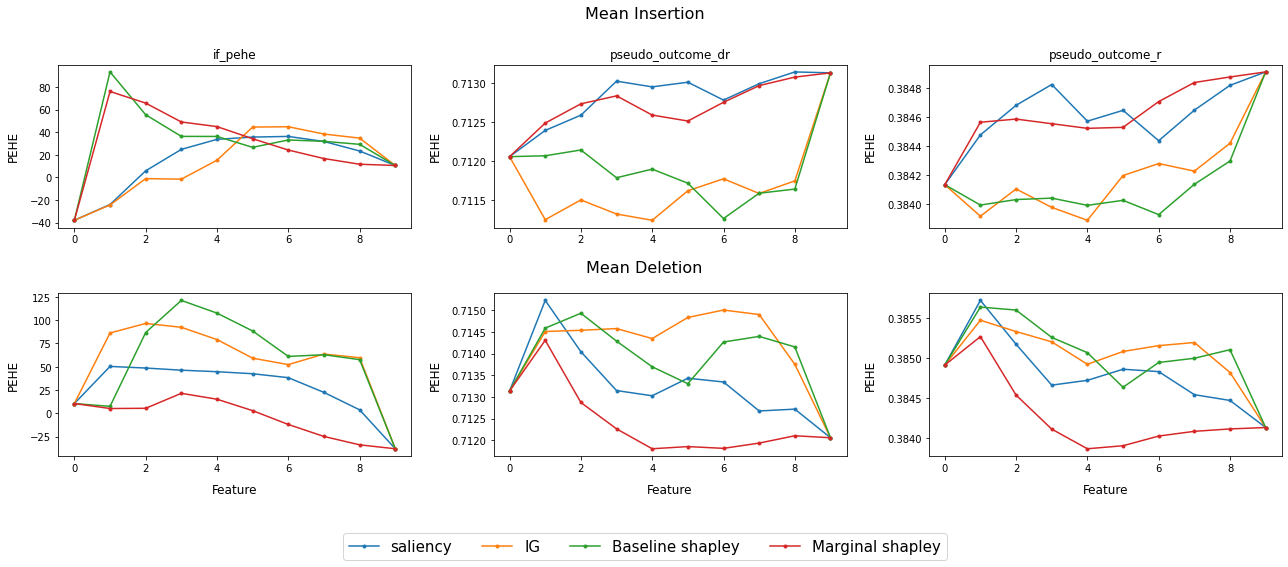

In [383]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

perturb_results = []

# Loop over the different files

seeds = [i for i in range(0, 5)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:
    file_path = f"../results/crash_2/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
    results = pkl.load(open(file_path,'rb'))
    
    for exp_index, exp in enumerate(explainers):
        auroc_all[exp].append(results[exp_index][5])
        auroc_ate[exp].append(results[exp_index][4])

        auroc_full.append(results[exp_index][7])
        auroc_full_ate.append(results[exp_index][6])

        auroc_random.append(results[exp_index][9])
        auroc_random_ate.append(results[exp_index][8])
        
        perturb_results.append(results[exp_index][10])
        
        for selection_type in selection_types:
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))


# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


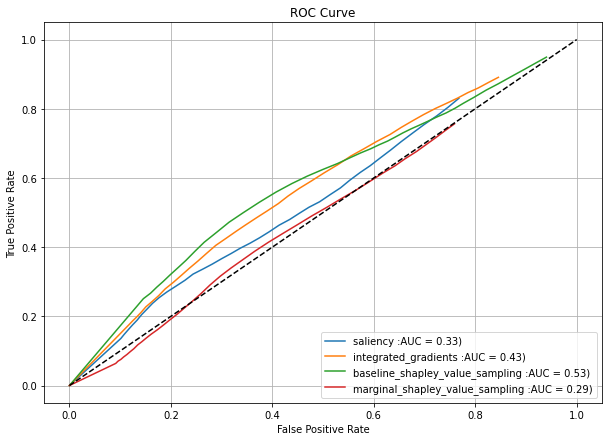

In [334]:
from sklearn.metrics import auc


plt.figure(figsize=(10, 7))

for i, exp in enumerate(explainers):
    
    data = np.mean(perturb_results[5*i:5*(i+1)], axis=0)

    # Calculate TPR and FPR
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])

    # Sort FPR and TPR in ascending order of FPR for plotting
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

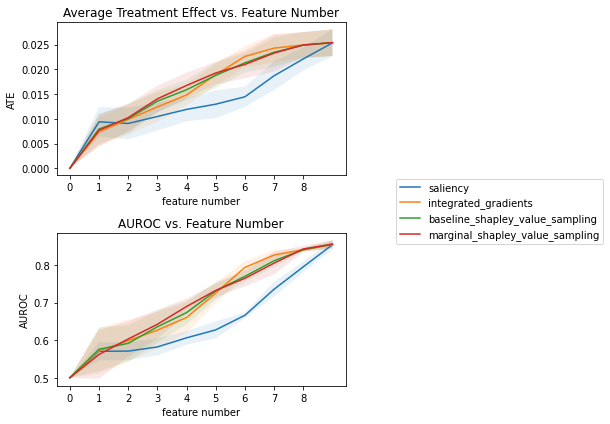

In [335]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}
auroc_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_all.items()}

ate_results = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}
ate_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_ate.items()}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,6))

# Plot ATE results
for k, v in ate_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
    ax1.fill_between(
        feature_num,
        np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
        np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
        alpha=0.1
    )

ax1.set_xticks(range(0, 9, 1))
ax1.set_xlabel("feature number")
ax1.set_ylabel("ATE")
ax1.set_title("Average Treatment Effect vs. Feature Number")

# Plot AUROC results
for k, v in auroc_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax2.plot(feature_num, np.insert(v, 0, 0.5), label=k)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0.5) + np.insert(auroc_std[k], 0, 0),
        np.insert(v, 0, 0.5) - np.insert(auroc_std[k], 0, 0),
        alpha=0.1
    )

ax2.set_xticks(range(0, 9, 1))
ax2.set_xlabel("feature number")
ax2.set_ylabel("AUROC")
ax2.set_title("AUROC vs. Feature Number")

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.7, 0.5))

plt.tight_layout()
plt.show()
